In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
import time
import json
from IPython.display import Image
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import pickle
import os
from collections import Counter
from sklearn.naive_bayes import GaussianNB

In [2]:
def save_obj(obj, name ):
    with open('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/survey/obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/survey/obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [28]:
dict_ = load_obj("user_cluster5_dict")

In [3]:
# student clustering
std = [(0, 2), (1, 2), (2, 2), (3, 0), (4, 2), (5, 2), (6, 1), (7, 0), (8, 0), (9, 2), (10, 2), (11, 1), (12, 1), (13, 0), (14, 0), (15, 1), (16, 0), (17, 0), (18, 0), (19, 2), (20, 0), (21, 2), (22, 2), (23, 0), (24, 1), (25, 1), (26, 2), (27, 2), (28, 1), (29, 0), (30, 2), (31, 0), (32, 0), (33, 0), (34, 2), (35, 1), (36, 0), (37, 0), (38, 1), (39, 2)]
student_cluster = dict(zip(*zip(*std)))
# real id mapping
real_id_mapping = {0: '00', 1: '01', 2: '02', 3: '03', 4: '04', 5: '05', 6: '07', 7: '09', 8: '10', 9: '14', 10: '15', 11: '16', 12: '17', 13: '18', 14: '19', 15: '20', 16: '23', 17: '24', 18: '27', 19: '30', 20: '31', 21: '32', 22: '33', 23: '34', 24: '35', 25: '36', 26: '42', 27: '43', 28: '44', 29: '45', 30: '47', 31: '49', 32: '51', 33: '52', 34: '53', 35: '56', 36: '58', 37: '59', 38: '46', 39: '54'}

In [4]:
student_cluster = {'u'+str(real_id_mapping[key]):value for key, value in student_cluster.items()}
student_cluster 

{'u00': 2,
 'u01': 2,
 'u02': 2,
 'u03': 0,
 'u04': 2,
 'u05': 2,
 'u07': 1,
 'u09': 0,
 'u10': 0,
 'u14': 2,
 'u15': 2,
 'u16': 1,
 'u17': 1,
 'u18': 0,
 'u19': 0,
 'u20': 1,
 'u23': 0,
 'u24': 0,
 'u27': 0,
 'u30': 2,
 'u31': 0,
 'u32': 2,
 'u33': 2,
 'u34': 0,
 'u35': 1,
 'u36': 1,
 'u42': 2,
 'u43': 2,
 'u44': 1,
 'u45': 0,
 'u46': 1,
 'u47': 2,
 'u49': 0,
 'u51': 0,
 'u52': 0,
 'u53': 2,
 'u54': 2,
 'u56': 1,
 'u58': 0,
 'u59': 0}

In [5]:
Counter(student_cluster.values())

Counter({0: 16, 1: 9, 2: 15})

### Phone Charge

In [2]:
ts = 1364114771
ts1 = 1364364806
datetime.utcfromtimestamp(ts1)- datetime.utcfromtimestamp(ts)

datetime.timedelta(2, 77235)

In [59]:
datetime.utcfromtimestamp(ts1).weekday()

2

In [3]:
datetime.fromtimestamp(ts1).strftime('%Y-%m-%d %H:%M:%S')

'2013-03-27 02:13:26'

In [2]:
# map
weekday_map = {0:"Monday",1:"Tuesday",2:'Wednesday',3:"Thursday",4:"Friday",5:'Saturday',6:'Sunday'}

In [41]:
def phonecharge(uid = 'u00', display = True):
    print("Phone Charge Report for user",uid)
    print("Cluster: ",student_cluster[uid])
    charge = pd.read_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/sensing/phonecharge/phonecharge_{}.csv'.format(uid)) 
    charge['start_time'] = charge['start'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    charge['end_time'] = charge['end'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    charge['duration'] = charge.apply(lambda row: datetime.fromtimestamp(int(row['end']))- datetime.fromtimestamp(int(row['start'])), axis=1)
    charge['date'] = charge['end'].apply(lambda x: datetime.fromtimestamp(x).date())
    charge['weekday'] = charge['end'].apply(lambda x: datetime.fromtimestamp(x).weekday()) # Monday:0
    
    
    # per day phone charge data
    charge_daily = pd.DataFrame()
    charge_daily['count'] = charge.groupby(['date'])['duration'].count()
    charge_daily['duration'] = charge.groupby(['date'])['duration'].sum()
    charge_daily['weekday'] = charge_daily.index.map(lambda s: s.weekday())#charge.groupby(['date'])['weekday'].unique().values
    charge_daily['duration_hr'] = charge_daily.apply(lambda row:row['duration'].seconds/3600,axis=1)
    print ("The average number of times user{} is charging his phone per day is: {}".format(uid,round(charge_daily['count'].mean())))
    
    # per weekday
    x_unique  = np.unique(charge_daily['weekday'])
    y_means = np.array([np.mean(charge_daily['duration'][charge_daily['weekday']==u]) for u in x_unique])
    y_stds = np.array([np.std(charge_daily['duration'][charge_daily['weekday']==u]) for u in x_unique])
    
    vfun = np.vectorize(lambda s:s.seconds/3600)
    charge_weekday_byhour_std = vfun(y_stds)
    charge_weekday_byhour_mean = vfun(y_means)
    
    print ("The average charging duration for user{} per day is: {} hrs".format(uid,round(np.mean(charge_weekday_byhour_mean),1)))
    if not display:
        return (charge_daily)
           
    # plot
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(10,5))
    fig.canvas.draw()
    ax.errorbar([range(7)],charge_weekday_byhour_mean.reshape([1,7]), yerr = charge_weekday_byhour_std.reshape(1,7),color='w',ecolor='m',fmt='')
    ax.plot([range(7)],charge_weekday_byhour_mean.reshape([1,7]),'-o',markersize=20,color='m')
    labels = [item.get_text() for item in ax.get_xticklabels()]

    for l in range(1,len(labels)):
        try:
            labels[l] = weekday_map[l-1]
        except:
            pass

    ax.set_xticklabels(labels)
    ax.set_xlabel(uid)
    ax.set_title('Weekly Average Phone Charge Duration')
    ax.yaxis.grid(True, dash_capstyle='round',linestyle=':')

    plt.show()
    
    return charge, charge_daily, charge_weekday_byhour_mean

Phone Charge Report for user u00
Cluster:  0
The average number of times useru00 is charging his phone per day is: 2
The average charging duration for useru00 per day is: 6.7 hrs


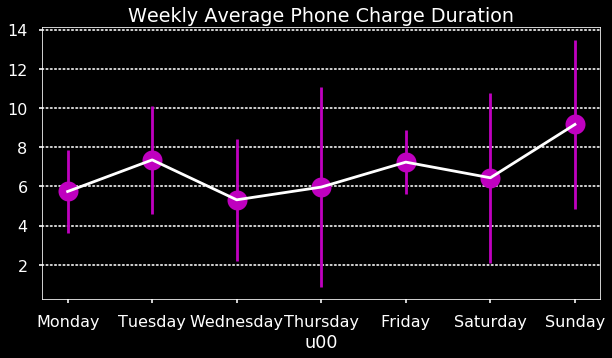

In [421]:
charge00, charge_daily00, charge_weekday_mean00 = phonecharge(uid = 'u00')

Phone Charge Report for user u10
Cluster:  2
The average number of times useru10 is charging his phone per day is: 2
The average charging duration for useru10 per day is: 4.1 hrs


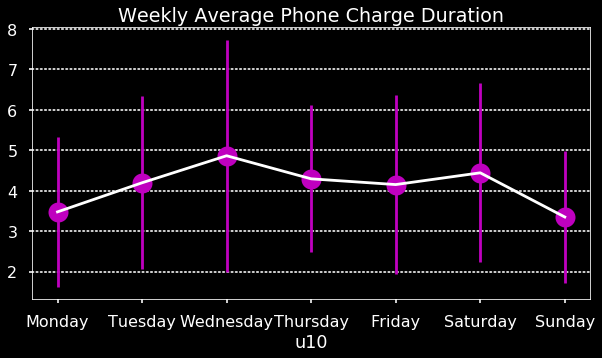

In [422]:
charge10, charge_daily10, charge_weekday_mean10 = phonecharge(uid = 'u10')

In [229]:
charge00

,start,end,start_time,end_time,duration,date,weekday
0,1364358885,1364364806,2013-03-27 04:34:45,2013-03-27 06:13:26,01:38:41,2013-03-27,2
1,1364365283,1364381933,2013-03-27 06:21:23,2013-03-27 10:58:53,04:37:30,2013-03-27,2
2,1364472718,1364478101,2013-03-28 12:11:58,2013-03-28 13:41:41,01:29:43,2013-03-28,3
3,1364479796,1364485621,2013-03-28 14:09:56,2013-03-28 15:47:01,01:37:05,2013-03-28,3
4,1364534372,1364541446,2013-03-29 05:19:32,2013-03-29 07:17:26,01:57:54,2013-03-29,4
5,1364541773,1364555031,2013-03-29 07:22:53,2013-03-29 11:03:51,03:40:58,2013-03-29,4
6,1364662852,1364670656,2013-03-30 17:00:52,2013-03-30 19:10:56,02:10:04,2013-03-30,5
7,1364708211,1364736236,2013-03-31 05:36:51,2013-03-31 13:23:56,07:47:05,2013-03-31,6
8,1364747939,1364756124,2013-03-31 16:38:59,2013-03-31 18:55:24,02:16:25,2013-03-31,6
9,1364791061,1364797191,2013-04-01 04:37:41,2013-04-01 06:19:51,01:42:10,2013-04-01,0


Phone Charge Report for user u23
Cluster:  2
The average number of times useru23 is charging his phone per day is: 3
The average charging duration for useru23 per day is: 9.0 hrs


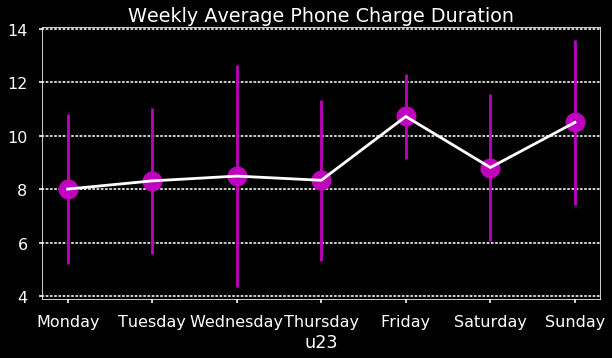

In [423]:
charge23, charge_daily23,charge_weekday_mean23 = phonecharge(uid = 'u23')

In [230]:
charge23

,start,end,start_time,end_time,duration,date,weekday
0,1364412960,1364418491,2013-03-27 19:36:00,2013-03-27 21:08:11,01:32:11,2013-03-27,2
1,1364477434,1364484968,2013-03-28 13:30:34,2013-03-28 15:36:08,02:05:34,2013-03-28,3
2,1364521495,1364533988,2013-03-29 01:44:55,2013-03-29 05:13:08,03:28:13,2013-03-29,4
3,1364582874,1364586739,2013-03-29 18:47:54,2013-03-29 19:52:19,01:04:25,2013-03-29,4
4,1364590459,1364611952,2013-03-29 20:54:19,2013-03-30 02:52:32,05:58:13,2013-03-30,5
5,1364652874,1364678017,2013-03-30 14:14:34,2013-03-30 21:13:37,06:59:03,2013-03-30,5
6,1364703447,1364731227,2013-03-31 04:17:27,2013-03-31 12:00:27,07:43:00,2013-03-31,6
7,1364734420,1364738675,2013-03-31 12:53:40,2013-03-31 14:04:35,01:10:55,2013-03-31,6
8,1364906894,1364925260,2013-04-02 12:48:14,2013-04-02 17:54:20,05:06:06,2013-04-02,1
9,1364996570,1365015185,2013-04-03 13:42:50,2013-04-03 18:53:05,05:10:15,2013-04-03,2


In [16]:
charge01, charge_daily01,charge_weekday_mean01 = phonecharge(uid = 'u01')

NameError: name 'phonecharge' is not defined

In [54]:
distance, path = fastdtw(charge_weekday_mean00,charge_weekday_mean18, dist=euclidean)
distance

10.96833333333333

In [15]:
distance

7.643611111111115

In [45]:
## Feature Extraction
focus = list(student_cluster.keys())

def prepare(column = 'duration_hr'): 

    charge_daily = phonecharge(uid = 'u00', display = False)
    charge_daily_merged = charge_daily[[column]]
    
    charge_daily_merged.columns = [column+'_u00']


    for i in focus:
            if i == 'u00':
                continue
            if i in student_cluster:
                charge_daily_i = phonecharge(uid = i, display = False)
                charge_daily_merged = charge_daily_merged.merge(charge_daily_i[[column]], left_index=True, right_index=True, how = 'left',suffixes=['','_'+i])

              
    charge_daily_merged = charge_daily_merged.rename(columns = {column:column+'_u01'})
    return charge_daily_merged.transpose() # row: user, column: time stamp

In [46]:
charge_all = prepare()
#charge_all.iloc[:,:33]

Phone Charge Report for user u00
Cluster:  2
The average number of times useru00 is charging his phone per day is: 2
The average charging duration for useru00 per day is: 6.7 hrs
Phone Charge Report for user u01
Cluster:  2
The average number of times useru01 is charging his phone per day is: 1
The average charging duration for useru01 per day is: 7.2 hrs
Phone Charge Report for user u02
Cluster:  2
The average number of times useru02 is charging his phone per day is: 2
The average charging duration for useru02 per day is: 6.8 hrs
Phone Charge Report for user u03
Cluster:  0
The average number of times useru03 is charging his phone per day is: 2
The average charging duration for useru03 per day is: 8.0 hrs
Phone Charge Report for user u04
Cluster:  2
The average number of times useru04 is charging his phone per day is: 1
The average charging duration for useru04 per day is: 7.4 hrs
Phone Charge Report for user u05
Cluster:  2
The average number of times useru05 is charging his phone pe

In [49]:
chargeall = pd.DataFrame()
chargeall['before_charge'] = charge_all[~np.isnan(charge_all)].iloc[:,:33].mean(axis=1)
chargeall['after_charge'] = charge_all[~np.isnan(charge_all)].iloc[:,33:].mean(axis=1)
chargeall = chargeall.reset_index()
chargeall['uid'] = chargeall['index'].apply(lambda x: x.split('_')[2])
chargeall.drop(['index'],inplace=True,axis=1)
chargeall.head()

,before_charge,after_charge,uid
0,6.907980,6.244295,u00
1,7.425152,7.372500,u01
2,7.585185,6.145208,u02
3,8.299505,7.817500,u03
4,7.659892,7.540278,u04


### Phone Lock

In [36]:
def phonelock(uid = 'u00', display = True, deseason = True):

    lock = pd.read_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/sensing/phonelock/phonelock_{}.csv'.format(uid)) 
    lock['start_time'] = lock['start'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    lock['end_time'] = lock['end'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    lock['duration'] = lock.apply(lambda row: datetime.fromtimestamp(int(row['end']))- datetime.fromtimestamp(int(row['start'])), axis=1)
    lock['date'] = lock['end'].apply(lambda x: datetime.fromtimestamp(x).date())
    lock['weekday'] = lock['end'].apply(lambda x: datetime.fromtimestamp(x).weekday()) # Monday:0
    
    # finding the induced sleep time
    idx = lock.groupby(['date'])['duration'].transform(max) == lock['duration']
    sleep_time = lock[idx].copy()
    sleep_time['duration_hr'] = sleep_time.apply(lambda row: row['duration'].seconds/3600,axis=1)
    sleep_time.set_index('date',inplace=True)
    
    # daily report
    lock_daily = pd.DataFrame()
    lock_daily['count'] = lock.groupby(['date'])['duration'].count()
    lock_daily['duration'] = lock.groupby(['date'])['duration'].sum()
    lock_daily['weekday'] = lock_daily.index.map(lambda s: s.weekday())
    lock_daily['duration_hr'] = lock_daily.apply(lambda row: 24-row['duration'].seconds/3600,axis=1)# frequent usage time total
    

    
    week_num = []
    count = 0 
    for i in lock_daily['weekday'].values:
        if i == 0:
            count += 1
            week_num.append(count)
        else:
            week_num.append(' ')
    if deseason == True:
        weekly_mean = dict(lock_daily.groupby(['weekday'])['duration_hr'].mean())
        weekly_sleep_mean = dict(sleep_time.groupby(['weekday'])['duration_hr'].mean())
        
        lock_daily['deseasoned_hr'] =  lock_daily.apply(lambda row: row['duration_hr']-weekly_mean[row['weekday']],axis=1)
        sleep_time['deseasoned_hr'] =  sleep_time.apply(lambda row: row['duration_hr']-weekly_sleep_mean[row['weekday']],axis=1)
    
    
        # plot
        if display == True:
            plt.rcdefaults()
            plt.style.use('seaborn-poster')
            fig, ax = plt.subplots()
            fig.canvas.draw()
            ax.plot(lock[idx]['start_time'],sleep_time['deseasoned_hr'],'-o',color='m',label="induced sleep time")

            ax.set_ylabel('hours')
            ax.set_title('Induced Sleep Time')
            ax.yaxis.grid(True, dash_capstyle='round',linestyle=':')

            ax.plot(lock[idx]['start_time'],lock_daily['deseasoned_hr'],'-o',color='y',label="frequent phone usage time")
            ax.set_xticklabels(week_num)
            ax.legend(loc="upper left")
            plt.show()

    else:
        # plot
        if display == True:
            print("Phone Lock Report for user",uid)
            print("Cluster: ",student_cluster[uid])
            plt.rcdefaults()
            plt.style.use('seaborn-poster')
            fig, ax = plt.subplots()
            fig.canvas.draw()
            ax.plot(lock[idx]['start_time'],sleep_time['duration_hr'],'-o',color='m',label="induced sleep time")
            #ax[0].set_xlabel('user0')
            #ax.set_xticks([])
            #ax.set_xticks(range(lock_daily.shape[0]))
            ax.set_ylabel('hours')
            ax.set_title('Induced Sleep Time')
            ax.yaxis.grid(True, dash_capstyle='round',linestyle=':')

        #     ax[1].plot(lock[idx]['start_time'],lock_daily['duration_hr'],'-o',color='m')
        #     ax[1].set_xlabel('user0')
        #     ax[1].set_xticks([])
        #     ax[1].set_ylabel('hours')
        #     ax[1].set_title('Frequent phone usage duration hour')
        #     ax[1].yaxis.grid(True, dash_capstyle='round',linestyle=':')
            ax.plot(lock[idx]['start_time'],lock_daily['duration_hr'],'-o',color='y',label="frequent phone usage time")
            ax.set_xticklabels(week_num)
        #     ax[0].set_xlabel('user0')
        #     ax[0].set_xticks([])
        #     ax[0].set_ylabel('hours')
        #     ax[0].set_title('Frequent phone usage duration hour')
        #     ax[0].yaxis.grid(True, dash_capstyle='round',linestyle=':')
            ax.legend(loc="upper left")
            plt.show()
    

    return lock, lock_daily, sleep_time

Phone Lock Report for user u00
Cluster:  2


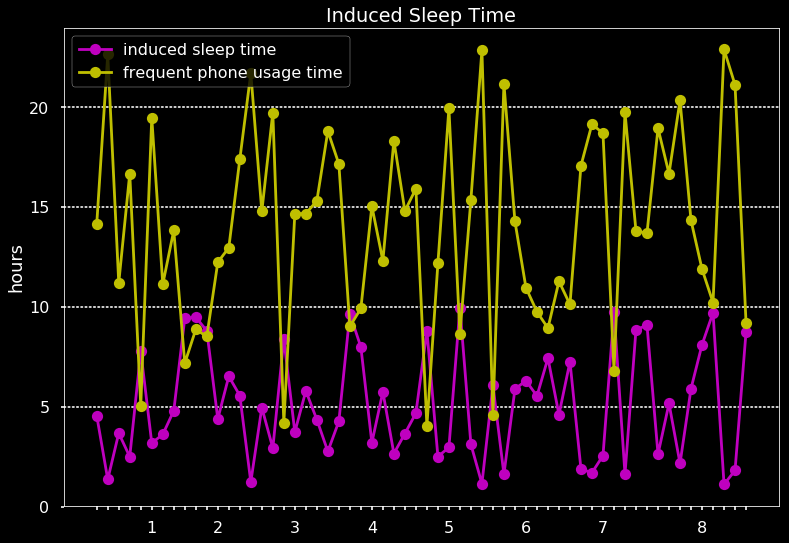

In [14]:
lock00,lock_daily00, sleep_time00 = phonelock(uid = 'u00',deseason=False)

Phone Lock Report for user u01
Cluster:  2


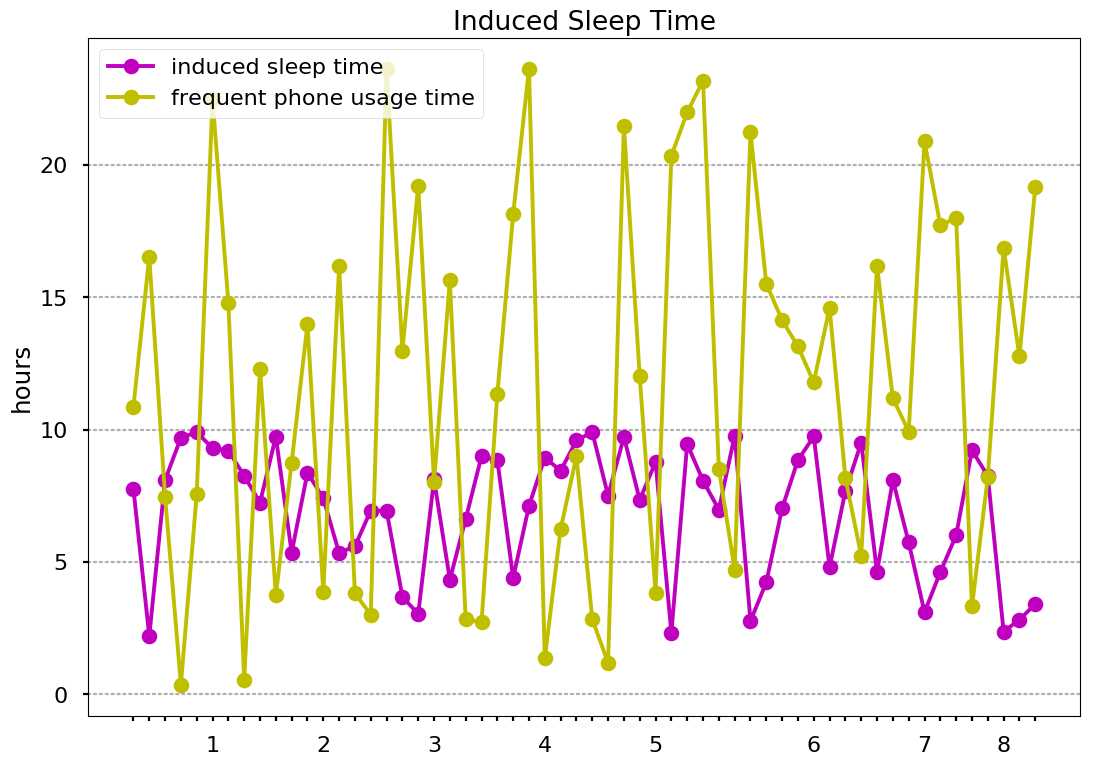

In [37]:
lock01,lock_daily01, sleep_time01 = phonelock(uid = 'u01',deseason= False)

Phone Lock Report for user u10
Cluster:  0


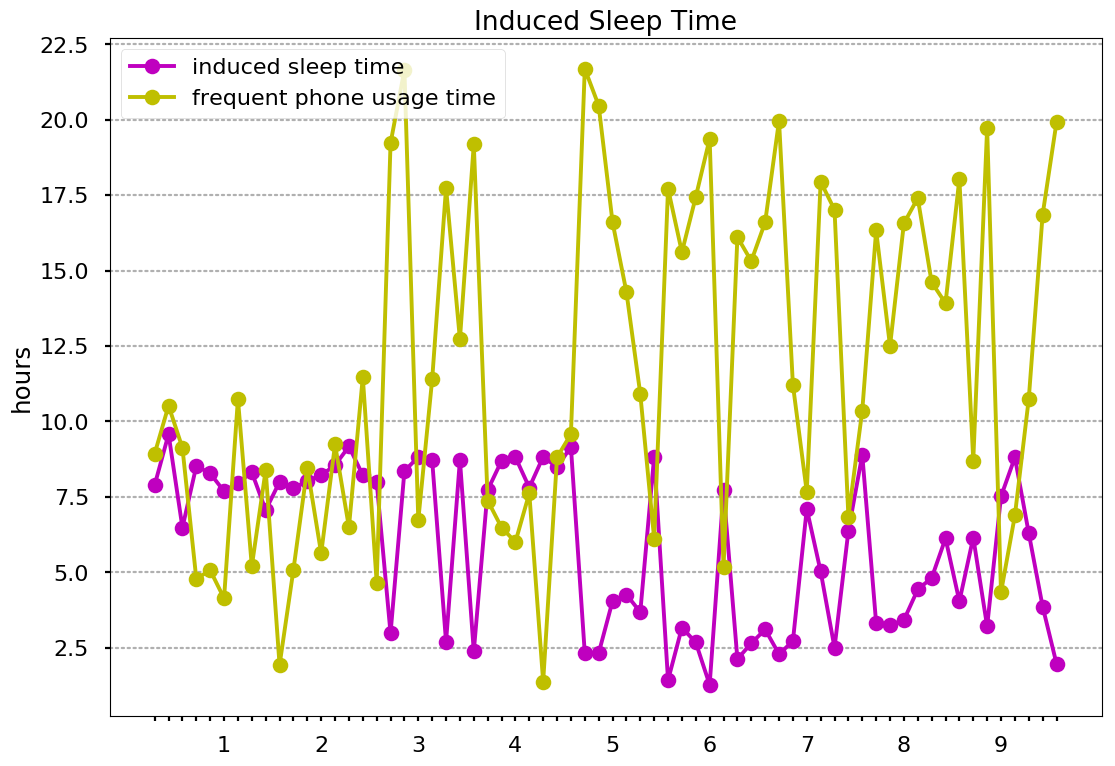

In [39]:
lock10,lock_daily10, sleep_time10 = phonelock(uid = 'u10',deseason=False)

### Dark

In [60]:
def dark(uid = 'u00', display = True, deseason = True):

    dark = pd.read_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/sensing/dark/dark_{}.csv'.format(uid)) 
    dark['start_time'] = dark['start'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    dark['end_time'] = dark['end'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    dark['duration'] = dark.apply(lambda row: datetime.fromtimestamp(int(row['end']))- datetime.fromtimestamp(int(row['start'])), axis=1)
    dark['date'] = dark['end'].apply(lambda x: datetime.fromtimestamp(x).date())
    dark['weekday'] = dark['end'].apply(lambda x: datetime.fromtimestamp(x).weekday()) # Monday:0
    
    # finding the induced sleep time
    idx = dark.groupby(['date'])['duration'].transform(max) == dark['duration']
    sleep_time = dark[idx].copy()
    sleep_time['duration_hr'] = sleep_time.apply(lambda row: row['duration'].seconds/3600,axis=1)
    sleep_time.set_index('date',inplace=True)
    
    # daily report
    dark_daily = pd.DataFrame()
    dark_daily['count'] = dark.groupby(['date'])['duration'].count()
    dark_daily['duration'] = dark.groupby(['date'])['duration'].sum()
    dark_daily['weekday'] = dark_daily.index.map(lambda s: s.weekday())
    dark_daily['duration_hr'] = dark_daily.apply(lambda row: 24-row['duration'].seconds/3600,axis=1)# frequent usage time total
 

    
    week_num = []
    count = 0 
    for i in dark_daily['weekday'].values:
        if i == 0:
            count += 1
            week_num.append(count)
        else:
            week_num.append(' ')
    if deseason == True:
        weekly_mean = dict(dark_daily.groupby(['weekday'])['duration_hr'].mean())
        weekly_sleep_mean = dict(sleep_time.groupby(['weekday'])['duration_hr'].mean())
        
        dark_daily['deseasoned_hr'] =  dark_daily.apply(lambda row: row['duration_hr']-weekly_mean[row['weekday']],axis=1)
        sleep_time['deseasoned_hr'] =  sleep_time.apply(lambda row: row['duration_hr']-weekly_sleep_mean[row['weekday']],axis=1)
    
    
        # plot
        if display == True:
            plt.style.use(['dark_background','seaborn-poster'])
            fig, ax = plt.subplots()
            fig.canvas.draw()
            ax.plot(dark[idx]['start_time'],sleep_time['deseasoned_hr'],'-o',color='m',label="induced sleep time")

            ax.set_ylabel('hours')
            ax.set_title('Induced Sleep Time')
            ax.yaxis.grid(True, dash_capstyle='round',linestyle=':')

            ax.plot(dark[idx]['start_time'],dark_daily['deseasoned_hr'],'-o',color='y',label="frequent phone usage time")
            ax.set_xticklabels(week_num)
            ax.legend(loc="upper left")
            plt.show()

    else:
        # plot
        if display == True:
            print("Phone dark Report for user",uid)
            print("Cluster: ",student_cluster[uid])
            plt.style.use(['dark_background','seaborn-poster'])
            fig, ax = plt.subplots()
            fig.canvas.draw()
            ax.plot(dark[idx]['start_time'],sleep_time['duration_hr'],'-o',color='m',label="induced sleep time")
            #ax[0].set_xlabel('user0')
            #ax.set_xticks([])
            #ax.set_xticks(range(dark_daily.shape[0]))
            ax.set_ylabel('hours')
            ax.set_title('Induced Sleep Time')
            ax.yaxis.grid(True, dash_capstyle='round',linestyle=':')

        #     ax[1].plot(dark[idx]['start_time'],dark_daily['duration_hr'],'-o',color='m')
        #     ax[1].set_xlabel('user0')
        #     ax[1].set_xticks([])
        #     ax[1].set_ylabel('hours')
        #     ax[1].set_title('Frequent phone usage duration hour')
        #     ax[1].yaxis.grid(True, dash_capstyle='round',linestyle=':')
            ax.plot(dark[idx]['start_time'],dark_daily['duration_hr'],'-o',color='y',label="frequent phone usage time")
            ax.set_xticklabels(week_num)
        #     ax[0].set_xlabel('user0')
        #     ax[0].set_xticks([])
        #     ax[0].set_ylabel('hours')
        #     ax[0].set_title('Frequent phone usage duration hour')
        #     ax[0].yaxis.grid(True, dash_capstyle='round',linestyle=':')
            ax.legend(loc="upper left")
            plt.show()
    

    return dark, dark_daily, sleep_time

In [65]:
focus = list(student_cluster.keys())

def prepare_dark(column = 'duration_hr'): # deseasoned_hr
    _,dark_daily_merged, sleep_time_merged = dark(uid = 'u00', display = False, deseason = False)
    dark_daily_merged = dark_daily_merged[[column]]
    sleep_time_merged = sleep_time_merged [[column]]
    dark_daily_merged.columns = [column+'_u00']
    sleep_time_merged.columns = [column+'_u00']

    for i in focus:
            if i == 'u00':
                continue
            if i in student_cluster:
                _,dark_daily, sleep_time = dark(uid = i,display=False,deseason = False)
                dark_daily_merged = dark_daily_merged.merge(dark_daily[[column]], left_index=True, right_index=True, how = 'left',suffixes=['','_'+i])

                sleep_time_merged = sleep_time_merged.merge(sleep_time[[column]], left_index=True, right_index=True, how = 'left',suffixes=['','_'+i])      

    dark_daily_merged = dark_daily_merged.rename(columns = {column:column+'_u01'})
    sleep_time_merged = sleep_time_merged.rename(columns = {column:column+'_u01'})
    return dark_daily_merged.transpose(), sleep_time_merged.transpose() # row: user, column: time stamp

In [68]:
dark_dailyall,dark_sleepall = prepare_dark()

In [73]:
dark_dailyall = dark_dailyall.reset_index()
dark_sleepall = dark_sleepall.reset_index()

In [74]:
darkall = pd.DataFrame()
darkall['before_play_dark'] = dark_dailyall.iloc[:,:35].mean(axis=1)
darkall['after_play_dark'] = dark_dailyall.iloc[:,35:].mean(axis=1)
darkall['uid'] = dark_dailyall['index'].apply(lambda x: x.split('_')[2])
darkall.head()

,before_play_dark,after_play_dark,uid
0,14.464984,18.061865,u00
1,10.872682,13.181389,u01
2,13.683811,15.224252,u02
3,15.297417,15.292049,u03
4,9.478562,9.631930,u04


In [78]:
darksleepall = pd.DataFrame()
darksleepall['before_sleep_dark'] = dark_sleepall.iloc[:,:35].mean(axis=1)
darksleepall['after_sleep_dark'] = dark_sleepall.iloc[:,35:].mean(axis=1)
darksleepall['uid'] = dark_sleepall['index'].apply(lambda x: x.split('_')[2])
darksleepall.head()

,before_sleep_dark,after_sleep_dark,uid
0,5.196797,3.815734,u00
1,6.220295,5.339788,u01
2,7.037578,5.630929,u02
3,5.470597,6.023958,u03
4,6.877917,6.324225,u04


In [76]:
phone=phone.merge(darkall,left_on = 'uid',right_on='uid',how='outer')
phone=phone.merge(darksleepall,left_on = 'uid',right_on='uid',how='outer')
phone.to_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/sensing/mydata/phone.csv',index=False)

In [85]:
phone.head()

,before_charge,after_charge,uid,before_play,after_play,before_sleep,after_sleep,before_play_dark,after_play_dark,before_sleep_dark,after_sleep_dark
0,6.907980,6.244295,u00,13.601242,14.762222,5.169559,4.987853,14.464984,18.061865,5.196797,3.815734
1,7.425152,7.372500,u01,10.305972,13.088465,7.288725,6.595863,10.872682,13.181389,6.220295,5.339788
2,7.585185,6.145208,u02,16.408628,17.776282,5.126701,4.443825,13.683811,15.224252,7.037578,5.630929
3,8.299505,7.817500,u03,13.975427,17.353000,6.703492,4.945583,15.297417,15.292049,5.470597,6.023958
4,7.659892,7.540278,u04,9.796633,10.765972,7.226574,7.100355,9.478562,9.631930,6.877917,6.324225


### prepare data

In [453]:
focus = list(student_cluster.keys())

def prepare(column = 'duration_hr'): # deseasoned_hr
    lock_daily_merged = lock_daily00[[column]]
    sleep_time_merged = sleep_time00[[column]]
    lock_daily_merged.columns = [column+'_u00']
    sleep_time_merged.columns = [column+'_u00']

    for i in focus:
            if i == 'u00':
                continue
            if i in student_cluster:
                _,lock_daily, sleep_time = phonelock(uid = i,display=False)
                lock_daily_merged = lock_daily_merged.merge(lock_daily[[column]], left_index=True, right_index=True, how = 'left',suffixes=['','_'+i])

                sleep_time_merged = sleep_time_merged.merge(sleep_time[[column]], left_index=True, right_index=True, how = 'left',suffixes=['','_'+i])      

    lock_daily_merged = lock_daily_merged.rename(columns = {column:column+'_u01'})
    sleep_time_merged = sleep_time_merged.rename(columns = {column:column+'_u01'})
    return lock_daily_merged.transpose(), sleep_time_merged.transpose() # row: user, column: time stamp

In [454]:
# regular
lock_daily,sleep_time = prepare(column = 'duration_hr')
# stationary
ds_lock_daily,ds_sleep_time = prepare(column = 'duration_hr')

In [455]:
sleep_time.to_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/sensing/mydata/sleep_time.csv')
ds_sleep_time.to_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/sensing/mydata/sleep_time.csv')   
lock_daily.to_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/sensing/mydata/lock_daily.csv')   
ds_lock_daily.to_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/sensing/mydata/ds_lock_daily.csv')   

In [229]:
# de-season using weekly avg
#dict(lock_daily10.groupby(['weekday'])['duration_hr'].mean())

{0: 10.215524691358025,
 1: 10.154783950617283,
 2: 11.338305555555555,
 3: 12.427305555555556,
 4: 11.114527777777777,
 5: 13.884222222222224,
 6: 11.741882716049382}

In [21]:
sleep_time = pd.read_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/sensing/mydata/sleep_time.csv')
lock_daily = pd.read_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/sensing/mydata/lock_daily.csv')

In [53]:
sleep_time.rename(columns = {'Unnamed: 0':'index'}, inplace = True)
sleep_time.head(1)

,index,2013-03-27,2013-03-28,2013-03-29,2013-03-30,2013-03-31,2013-04-01,2013-04-02,2013-04-03,2013-04-05,...,2013-05-17,2013-05-19,2013-05-23,2013-05-24,2013-05-26,2013-05-27,2013-05-28,2013-05-29,2013-05-30,2013-05-31
0,duration_hr_u00,4.546667,1.356667,3.673889,2.4925,7.775833,3.179167,3.609444,4.796389,9.429167,...,9.069722,2.6225,5.16,2.155833,5.905556,8.1025,9.708333,1.109722,1.808056,8.753333


In [34]:
lock_daily.rename(columns = {'Unnamed: 0':'index'}, inplace = True)
lock_daily.head(1)

,index,2013-03-27,2013-03-28,2013-03-29,2013-03-30,2013-03-31,2013-04-01,2013-04-02,2013-04-03,2013-04-05,...,2013-05-17,2013-05-19,2013-05-23,2013-05-24,2013-05-26,2013-05-27,2013-05-28,2013-05-29,2013-05-30,2013-05-31
0,duration_hr_u00,14.155,22.643333,11.205556,16.675833,5.0425,19.480833,11.1325,13.827222,7.175278,...,13.7025,18.943889,16.669167,20.336111,14.326667,11.888333,10.213889,22.890278,21.118611,9.194444


In [52]:
##### Extract Feaures

In [39]:
lockall = pd.DataFrame()
lockall['before_play'] = lock_daily.iloc[:,:35].mean(axis=1)
lockall['after_play'] = lock_daily.iloc[:,35:].mean(axis=1)
lockall['uid'] = lock_daily['index'].apply(lambda x: x.split('_')[2])
lockall.head()

,before_play,after_play,uid
0,13.601242,14.762222,u00
1,10.305972,13.088465,u01
2,16.408628,17.776282,u02
3,13.975427,17.353000,u03
4,9.796633,10.765972,u04


In [56]:
sleepall = pd.DataFrame()
sleepall['before_sleep'] = sleep_time.iloc[:,:35].mean(axis=1)
sleepall['after_sleep'] = sleep_time.iloc[:,35:].mean(axis=1)
sleepall['uid'] = sleep_time['index'].apply(lambda x: x.split('_')[2])
sleepall.head()

,before_sleep,after_sleep,uid
0,5.169559,4.987853,u00
1,7.288725,6.595863,u01
2,5.126701,4.443825,u02
3,6.703492,4.945583,u03
4,7.226574,7.100355,u04


In [57]:
### combine
phone = chargeall.merge(lockall,left_on = 'uid',right_on='uid',how='outer')
phone = phone.merge(sleepall,left_on = 'uid',right_on='uid',how='outer')
phone

,before_charge,after_charge,uid,before_play,after_play,before_sleep,after_sleep
0,6.907980,6.244295,u00,13.601242,14.762222,5.169559,4.987853
1,7.425152,7.372500,u01,10.305972,13.088465,7.288725,6.595863
2,7.585185,6.145208,u02,16.408628,17.776282,5.126701,4.443825
3,8.299505,7.817500,u03,13.975427,17.353000,6.703492,4.945583
4,7.659892,7.540278,u04,9.796633,10.765972,7.226574,7.100355
5,8.887822,2.793403,u05,12.436471,14.822066,6.994453,5.839774
6,9.443915,4.418681,u07,10.180208,13.163148,7.777300,7.790617
7,6.821716,6.916667,u09,10.391667,10.083750,7.242101,7.954421
8,4.150051,4.178125,u10,10.011863,13.625395,7.228252,4.484733
9,7.137541,5.437063,u14,9.693771,14.505880,6.791136,4.654923


In [86]:
phone.to_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/sensing/mydata/phone.csv',index=False)

### Classification

In [457]:
def add_cluster(dt, with_index=False):
    if with_index:
        dt = dt.reset_index().rename(columns = {'index':'uid'})
    
    dt['cluster'] = dt.apply(lambda row: student_cluster[row['uid'][-3:]],axis=1)
    return dt

In [464]:
# add cluster
ds_lock_daily = add_cluster(ds_lock_daily,True)

# get X and Y
X = ds_lock_daily.iloc[:,1:-1]
y = ds_lock_daily.iloc[:,-1]

# fill in NA in X
user_mean = ds_lock_daily.mean(axis=1).to_dict()
X = X.transpose().fillna(user_mean).transpose()

X.head()

date,2013-03-27,2013-03-28,2013-03-29,2013-03-30,2013-03-31,2013-04-01,2013-04-02,2013-04-03,2013-04-05,2013-04-06,...,2013-05-17,2013-05-19,2013-05-23,2013-05-24,2013-05-26,2013-05-27,2013-05-28,2013-05-29,2013-05-30,2013-05-31
0,14.155000,22.643333,11.205556,16.675833,5.042500,19.480833,11.132500,13.827222,7.175278,8.872222,...,13.702500,18.943889,16.669167,20.336111,14.326667,11.888333,10.213889,22.890278,21.118611,9.194444
1,10.864167,16.533056,7.469444,0.359167,7.568889,22.489444,14.793333,0.544444,3.741111,8.755833,...,16.187222,9.928611,3.324444,11.094146,8.205278,16.869444,12.770278,19.158611,11.094146,11.094146
2,15.403056,16.767109,12.831667,16.928889,15.825000,12.068889,20.380556,15.362222,19.956389,21.654722,...,21.116667,22.909167,14.091389,16.686667,17.967500,16.362222,20.271111,19.157500,14.553056,18.249444
3,1.460833,11.689722,12.289722,16.080833,1.945833,12.731389,14.534409,14.190000,14.215556,14.534409,...,14.534409,14.534409,14.534409,14.534409,14.534409,14.534409,14.534409,14.534409,14.534409,14.534409
4,7.291389,6.159722,8.416389,7.723333,0.580278,3.433611,4.327778,3.362500,4.437500,23.782778,...,13.960278,20.677500,9.943777,9.943777,9.943777,9.943777,9.943777,9.943777,9.943777,9.943777


In [469]:
# Cross Validation
def cross_val(X, y, k=5):
    # X: data frame
    # y: Series
    # k: num of folds
    num_student = X.shape[0]
    split_size = np.floor(num_student/k)
    acc = []
    cuts = []
    for i in range(num_student):

        if i%split_size == 0:
            cuts.append(i)
            
    cuts.append(num_student)
    print (cuts)
    # shuffle rows
    X = X.sample(frac=1,random_state=2018)
    y = y.sample(frac=1,random_state=2018)
    
    
    # make splits
    splits_x = {} # 0: data, 1: data
    splits_y = {}
    for i in range(k):
        splits_x[i] = X.iloc[cuts[i]:cuts[i+1],:]
        splits_y[i] = y.iloc[cuts[i]:cuts[i+1]]
        
        
        
    # cross validate
    for i, test_x in splits_x.items():

        train_j = [j_k for j_k,_ in splits_x.items() if j_k != i] 

        train_x = pd.DataFrame()
        train_y = pd.Series()
        for j in train_j:
            train_x=train_x.append(splits_x[j])#,ignore_index=True)
            train_y=train_y.append(splits_y[j])#,ignore_index=True)

        test_y = splits_y[i]

        # NB code
        
        # train the model
        gnb_model = GaussianNB()

        # given time series, predict cluster
        gnb_model.fit(train_x,train_y)
        
        # test the model
        y_pred = gnb_model.predict(test_x)
        print('real: ',test_y.values)
        print('pred: ',y_pred)
        print("Number of correctly labeled points out of a total %d points : %d" % (test_x.shape[0],(test_y == y_pred).sum()))
        acc.append ((test_y == y_pred).sum()/test_x.shape[0])

    print ('Cross Validation Accuracy for {} folds: {}'.format(k,acc))
    print('Accuracy:', np.average(acc))
    return splits_x,splits_y # can be other things you want

In [472]:
xx,yy=cross_val(X, y, k=5)

[0, 8, 16, 24, 32, 40]
real:  [2 1 2 0 0 0 0 1]
pred:  [1 2 2 0 2 2 2 2]
Number of correctly labeled points out of a total 8 points : 2
real:  [2 2 0 0 0 0 2 2]
pred:  [2 2 1 2 2 0 2 0]
Number of correctly labeled points out of a total 8 points : 4
real:  [2 2 2 2 1 0 2 2]
pred:  [0 0 0 0 2 2 0 2]
Number of correctly labeled points out of a total 8 points : 1
real:  [2 0 2 2 1 1 2 2]
pred:  [0 2 2 2 2 0 2 0]
Number of correctly labeled points out of a total 8 points : 3
real:  [1 1 2 1 0 0 0 1]
pred:  [2 2 2 2 2 2 2 2]
Number of correctly labeled points out of a total 8 points : 1
Cross Validation Accuracy for 5 folds: [0.25, 0.5, 0.125, 0.375, 0.125]
Accuracy: 0.275


### Education

In [511]:
# grades
grades = pd.read_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/education/grades.csv')
piazza = pd.read_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/education/piazza.csv')
deadline = pd.read_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/education/deadlines.csv')
class_info = pd.read_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/education/class.csv', names=['uid','c1','c2','c3','c4'])
with open('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/education/class_info.json') as f:
    class_meta = json.load(f)

In [512]:
# finding the target group
grades = grades[grades.uid.isin(student_cluster)] # 24
piazza = piazza[piazza.uid.isin(student_cluster)] # 40
deadline = deadline[deadline.uid.isin(student_cluster)] # 36
class_info = class_info[class_info.uid.isin(student_cluster)] # 40

In [513]:
grades = add_cluster(grades)
piazza = add_cluster(piazza)
deadline = deadline.iloc[:,:67]
deadline = add_cluster(deadline)
class_info = add_cluster(class_info)

In [477]:
student_cluster

{'u00': 0,
 'u01': 0,
 'u02': 2,
 'u03': 2,
 'u04': 0,
 'u05': 0,
 'u07': 1,
 'u09': 2,
 'u10': 2,
 'u14': 0,
 'u15': 2,
 'u16': 1,
 'u17': 1,
 'u18': 2,
 'u19': 2,
 'u20': 1,
 'u23': 2,
 'u24': 2,
 'u27': 2,
 'u30': 0,
 'u31': 2,
 'u32': 0,
 'u33': 0,
 'u34': 2,
 'u35': 1,
 'u36': 1,
 'u42': 0,
 'u43': 0,
 'u44': 1,
 'u45': 2,
 'u46': 1,
 'u47': 0,
 'u49': 2,
 'u51': 2,
 'u52': 2,
 'u53': 0,
 'u54': 1,
 'u56': 0,
 'u58': 2,
 'u59': 2}

In [ ]:
## grades
# cluster 0:8 pretty high almost everyone 4.0, 1: 5, 2: 11(high variance)

In [485]:
grades.groupby(['cluster'])[' cs 65'].mean()

cluster
0    3.833333
1    4.000000
2    3.272727
Name:  cs 65, dtype: float64

In [486]:
grades.groupby(['cluster'])[' gpa all'].mean()

cluster
0    3.403125
1    3.462400
2    3.405818
Name:  gpa all, dtype: float64

In [487]:
grades.groupby(['cluster'])[' gpa 13s'].mean()

cluster
0    3.440972
1    3.177778
2    3.353535
Name:  gpa 13s, dtype: float64

In [493]:
grades[grades.cluster == 1]

,uid,gpa all,gpa 13s,cs 65,cluster
4,u07,3.474,4.000000,4.0,1
11,u16,3.373,4.000000,4.0,1
12,u17,3.476,3.333333,4.0,1
24,u46,3.646,1.111111,4.0,1
27,u54,3.343,3.444444,4.0,1


In [497]:
piazza[piazza.cluster == 1]

,uid,days online,views,contributions,questions,notes,answers,cluster
6,u07,43,201,12,1,0,0,1
14,u16,41,201,3,0,0,0,1
15,u17,57,306,26,11,2,4,1
18,u20,63,181,2,0,0,0,1
29,u35,13,94,0,0,0,0,1
30,u36,16,52,4,4,0,0,1
35,u44,30,71,0,0,0,0,1
37,u46,68,302,14,7,0,1,1
44,u54,33,147,3,1,0,0,1


In [498]:
X = piazza.iloc[:,1:-2]
y = piazza.iloc[:,-1]
xx,yy=cross_val(X, y, k=5)

[0, 8, 16, 24, 32, 40]
real:  [2 2 2 0 0 0 0 1]
pred:  [1 1 0 2 1 2 1 2]
Number of correctly labeled points out of a total 8 points : 0
real:  [2 2 1 0 0 0 0 2]
pred:  [2 2 2 2 1 1 1 2]
Number of correctly labeled points out of a total 8 points : 3
real:  [2 2 1 2 1 0 2 2]
pred:  [2 2 1 2 0 2 1 1]
Number of correctly labeled points out of a total 8 points : 4
real:  [2 0 0 2 1 1 2 2]
pred:  [0 0 1 1 2 2 1 2]
Number of correctly labeled points out of a total 8 points : 2
real:  [1 1 2 1 0 0 2 2]
pred:  [1 1 2 1 1 2 1 1]
Number of correctly labeled points out of a total 8 points : 4
Cross Validation Accuracy for 5 folds: [0.0, 0.375, 0.5, 0.25, 0.5]
Accuracy: 0.325


In [499]:
X = grades.iloc[:,1:-2]
y = grades.iloc[:,-1]
xx,yy=cross_val(X, y, k=5)

[0, 4, 8, 12, 16, 20, 24]
real:  [1 0 1 0]
pred:  [2 2 2 2]
Number of correctly labeled points out of a total 4 points : 0
real:  [2 0 0 2]
pred:  [2 2 2 0]
Number of correctly labeled points out of a total 4 points : 1
real:  [2 0 2 1]
pred:  [0 2 0 0]
Number of correctly labeled points out of a total 4 points : 0
real:  [2 1 2 2]
pred:  [0 0 2 0]
Number of correctly labeled points out of a total 4 points : 1
real:  [0 0 2 2]
pred:  [2 2 1 1]
Number of correctly labeled points out of a total 4 points : 0
Cross Validation Accuracy for 5 folds: [0.0, 0.25, 0.0, 0.25, 0.0]
Accuracy: 0.1


In [514]:
deadline['total'] = deadline.sum(axis=1)

In [515]:
X = deadline[['total']]
y = deadline['cluster']

In [516]:
xx,yy=cross_val(X, y, k=5)

[0, 7, 14, 21, 28, 35, 36]
real:  [0 1 0 2 0 1 2]
pred:  [2 2 2 2 0 0 1]
Number of correctly labeled points out of a total 7 points : 2
real:  [2 2 2 1 0 2 0]
pred:  [1 1 1 1 1 2 2]
Number of correctly labeled points out of a total 7 points : 2
real:  [0 2 2 2 1 0 2]
pred:  [1 1 0 2 1 0 1]
Number of correctly labeled points out of a total 7 points : 3
real:  [1 2 2 2 2 1 1]
pred:  [0 0 0 0 0 0 0]
Number of correctly labeled points out of a total 7 points : 0
real:  [2 1 2 0 0 0 2]
pred:  [2 2 2 2 2 2 2]
Number of correctly labeled points out of a total 7 points : 3
Cross Validation Accuracy for 5 folds: [0.2857142857142857, 0.2857142857142857, 0.42857142857142855, 0.0, 0.42857142857142855]
Accuracy: 0.285714285714
